# Problem Session 10
## Classifying Cancer IV

This notebook will be the final time you work with the cancer data set that can be found here, <a href="https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29">https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29</a>. 


The problems in this notebook will cover the content covered in some of our `Classification`, `Dimension Reduction` and our `Ensemble Learning` notebooks. In particular we will cover content touched on in.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

##### 1. Load, train test split

First load the data then make a train test split.

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [3]:
## Loads the data from sklearn 
cancer = load_breast_cancer(as_frame=True)

## the 'data' entry contains the features
X = cancer['data']

## the 'target' entry contains what we would like to predict
y = cancer['target']

## switching labels for malignant and benign
y = -y + 1

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(),
                                                       shuffle=True,
                                                       random_state=354,
                                                       test_size=.2,
                                                       stratify=y)

##### 2. What have we done?

Below I will provide you with a quick refresher of everything we have done with this data set up to this point.

##### Classifying Cancer I

In Classifying Cancer I you:
- Explored the data set,
- Considered different performance metrics for a classifier built on these data,
- Built some logistic regression models using a single feature,
- Build a $k$-nearest neighbors model and
- Interpreted your model in terms of what a $1$ or $0$ indicates for a patients probability of having a malignant tumor.

##### Classifying Cancer II

In Classifying Cancer II you:
- Examined the impact of PCA on your $k$NN model,
- Tried some Bayes' based classifiers and
- Produced Fisher discriminants for these data.

##### Classifying Cancer III

In Classifying Cancer III you:
- Combined a support vector classifier with PCA,
- Built a decision tree model and
- Built a random forest model.

In today's notebook you will look to build a couple of ensemble models with the hope that we could hone in on a final model choice on these data. In particular, you will look for models that maximize the TPR, FPR and precision.

##### 3. A Baseline.

A common baseline for classification is just randomly guessing, i.e. a biased coin flip where the probability of heads is equal to the probability of being class $1$.

Use the training set to get an estimate of the TPR, FPR and precision of such a model. 

<i>Note: a point estimate is fine for this problem. No need to estimate over several runs and get an average.</i>

##### Sample Solution

In [5]:
from sklearn.metrics import confusion_matrix, precision_score

In [6]:
np.random.seed(440)
y_baseline = np.random.binomial(1, np.sum(y_train==1)/len(y_train), len(y_train))

base_conf_mat = confusion_matrix(y_train, y_baseline)

In [7]:
print("Precision", precision_score(y_train, y_baseline))
print("TPR", base_conf_mat[1,1]/(base_conf_mat[1,0] + base_conf_mat[1,1]))
print("FPR", base_conf_mat[0,1]/(base_conf_mat[0,0] + base_conf_mat[0,1]))

Precision 0.39204545454545453
TPR 0.40588235294117647
FPR 0.37543859649122807


##### 4. AdaBoost

Now try to build an adaptive boosting classifier on these data.

Use cross-validation to determine the optimal value for `n_estimators` for an `AdaBoostClassifier` using a `DecisionTreeClassifier` with `max_depth=2` as its base estimator. Set the `learning_rate=1` in the `AdaBoostClassifier`.

To help save you some time I have provided most of the cross-validation code for you and have commented portions where you will need to fill in to get to your answer.

In [8]:
# import the appropriate items here
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [9]:
## We'll search from 1 to 100 weak learners
num_learners = range(1,101)

## Make an array to hold your cross validation results here
ada_tprs = np.zeros((5, len(num_learners)))
ada_fprs = np.zeros((5, len(num_learners)))
ada_precs = np.zeros((5, len(num_learners)))


## fill in the code for a 5-fold cross-validation object here
kfold = StratifiedKFold(5, shuffle=True, random_state=413)


i=0
for train_index, test_index in kfold.split(X_train, y_train):
    # this will help you keep track of what kfold split you are on
    print(i)
    
    # this gets the training and holdout sets
    X_tt = X_train.iloc[train_index]
    X_ho = X_train.iloc[test_index]
    y_tt = y_train.iloc[train_index]
    y_ho = y_train.iloc[test_index]
    
    # here we loop through the different values for n_estimators
    for j in num_learners:
        # make the AdaBoostClassifier object here
        ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, random_state=223), 
                                 n_estimators=j, 
                                 learning_rate=1)
        
        # fit that object here
        ada.fit(X_tt.values, y_tt)
        
        # get the prediction on the holdout data
        pred = ada.predict(X_ho.values)
        
        # record the performance in your array here
        conf_mat = confusion_matrix(y_ho, pred)
        
        ada_tprs[i,j-1] = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
        ada_fprs[i,j-1] = conf_mat[0,1]/(conf_mat[0,0] + conf_mat[0,1])
        ada_precs[i,j-1] = precision_score(y_ho, pred)

        j = j + 1
    i = i + 1

0
1
2
3
4


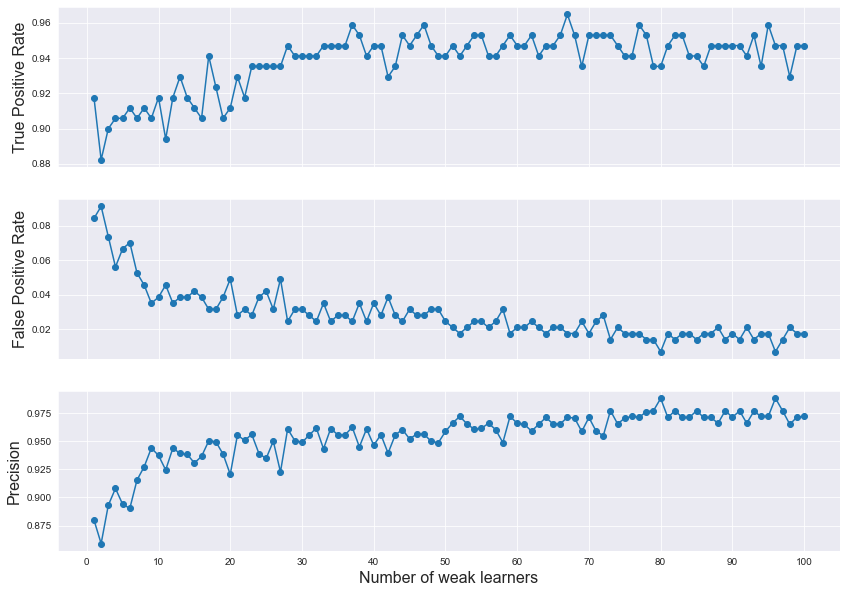

In [10]:
fig,ax = plt.subplots(3,1, figsize=(14,10), sharex=True)

## TPR
ax[0].plot(num_learners, np.mean(ada_tprs, axis=0), '-o')
ax[0].set_ylabel("True Positive Rate", fontsize=16)

## FPR
ax[1].plot(num_learners, np.mean(ada_fprs, axis=0), '-o')
ax[1].set_ylabel("False Positive Rate", fontsize=16)

## Precs
ax[2].plot(num_learners, np.mean(ada_precs, axis=0), '-o')
ax[2].set_ylabel("Precision", fontsize=16)

ax[2].set_xlabel("Number of weak learners", fontsize=16)
ax[2].set_xticks(np.arange(0,110,10))

plt.show()

<i>How many weak learners would you choose for this model?</i>

##### Sample Answer

$90$ seems reasonable enough.

##### 5. Comparing different models

Use $5$-fold cross-validation to compare the following models:
- A pipeline that runs the data through PCA with an explained variance ratio of `0.85` and then a $k$NN model with $k = 5$,
- A random forest model with `n_estimators=500`, `max_samples=200` and `max_depth=5`,
- A pipeline that runs the data through PCA with an explained variance ratio of `0.90` and then a support vector machine with the `rbf` kernel and `C=1`,
- The AdaBoost model you selected from 5. above and
- A voter model consisting of the four previous models.

Again I will provide some shell code for you to fill in the blanks to help speed things along.

##### Sample Solution

In [11]:
## import things here
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

In [12]:
cv_tprs = np.zeros((5, 5))
cv_fprs = np.zeros((5, 5))
cv_precs = np.zeros((5, 5))

## fill in the code for a 5-fold cross-validation object here
kfold = StratifiedKFold(5, shuffle=True, random_state=413)


i=0
for train_index, test_index in kfold.split(X_train, y_train):
    # this gets the training and holdout sets
    X_tt = X_train.iloc[train_index]
    X_ho = X_train.iloc[test_index]
    y_tt = y_train.iloc[train_index]
    y_ho = y_train.iloc[test_index]
    
    ### Making Model Objects ###
    ## Make the knn model
    knn_pipe = Pipeline([('scale', StandardScaler()),
                            ('pca', PCA(.85)),
                            ('knn', KNeighborsClassifier(5))])
    
    ## Make the random forest model
    rf = RandomForestClassifier(n_estimators = 1500,
                                   max_depth = 5,
                                   max_samples = 200,
                                   random_state = 330)
    
    ## Make the SVM model
    svc_pipe = Pipeline([('scale', StandardScaler()),
                            ('pca', PCA(.9)),
                            ('knn', SVC(kernel='rbf'))])
    
    ## Make the adaboost model
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, random_state=223), 
                                 n_estimators=90, 
                                 learning_rate=1)
    
    ## Make the voting Model
    vote = VotingClassifier([('knn', Pipeline([('scale', StandardScaler()),
                                                ('pca', PCA(.85)),
                                                ('knn', KNeighborsClassifier(5))])),
                                ('rf', RandomForestClassifier(n_estimators = 1500,
                                                                   max_depth = 5,
                                                                   max_samples = 200,
                                                                   random_state = 330)),
                                ('svc', Pipeline([('scale', StandardScaler()),
                                                    ('pca', PCA(.9)),
                                                    ('knn', SVC(kernel='rbf'))])),
                                ('ada', AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, 
                                                                                  random_state=223), 
                                                             n_estimators=90, 
                                                             learning_rate=1))])
    
    ### Train Model objects ###
    knn_pipe.fit(X_tt.values, y_tt)
    rf.fit(X_tt.values, y_tt)
    svc_pipe.fit(X_tt.values, y_tt)
    ada.fit(X_tt.values, y_tt)
    vote.fit(X_tt.values, y_tt)
    
    ### Get the predictions ###
    knn_pred = knn_pipe.predict(X_ho.values)
    rf_pred = rf.predict(X_ho.values)
    svc_pred = svc_pipe.predict(X_ho.values)
    ada_pred = ada.predict(X_ho.values)
    vote_pred = vote.predict(X_ho.values)
    
    ### Record the performance ###
    cv_precs[i, 0] = precision_score(y_ho, knn_pred)
    cv_precs[i, 1] = precision_score(y_ho, rf_pred)
    cv_precs[i, 2] = precision_score(y_ho, svc_pred)
    cv_precs[i, 3] = precision_score(y_ho, ada_pred)
    cv_precs[i, 4] = precision_score(y_ho, vote_pred)
    
    
    
    knn_conf_mat = confusion_matrix(y_ho, knn_pred)
    rf_conf_mat = confusion_matrix(y_ho, rf_pred)
    svc_conf_mat = confusion_matrix(y_ho, svc_pred)
    ada_conf_mat = confusion_matrix(y_ho, ada_pred)
    vote_conf_mat = confusion_matrix(y_ho, vote_pred)
    
    cv_tprs[i, 0] = knn_conf_mat[1,1]/(knn_conf_mat[1,0] + knn_conf_mat[1,1])
    cv_tprs[i, 1] = rf_conf_mat[1,1]/(rf_conf_mat[1,0] + rf_conf_mat[1,1])
    cv_tprs[i, 2] = svc_conf_mat[1,1]/(svc_conf_mat[1,0] + svc_conf_mat[1,1])
    cv_tprs[i, 3] = ada_conf_mat[1,1]/(ada_conf_mat[1,0] + ada_conf_mat[1,1])
    cv_tprs[i, 4] = vote_conf_mat[1,1]/(vote_conf_mat[1,0] + vote_conf_mat[1,1])
    
    cv_fprs[i, 0] = knn_conf_mat[0,1]/(knn_conf_mat[0,0] + knn_conf_mat[0,1])
    cv_fprs[i, 1] = rf_conf_mat[0,1]/(rf_conf_mat[0,0] + rf_conf_mat[0,1])
    cv_fprs[i, 2] = svc_conf_mat[0,1]/(svc_conf_mat[0,0] + svc_conf_mat[0,1])
    cv_fprs[i, 3] = ada_conf_mat[0,1]/(ada_conf_mat[0,0] + ada_conf_mat[0,1])
    cv_fprs[i, 4] = vote_conf_mat[0,1]/(vote_conf_mat[0,0] + vote_conf_mat[0,1])

    
    i = i + 1

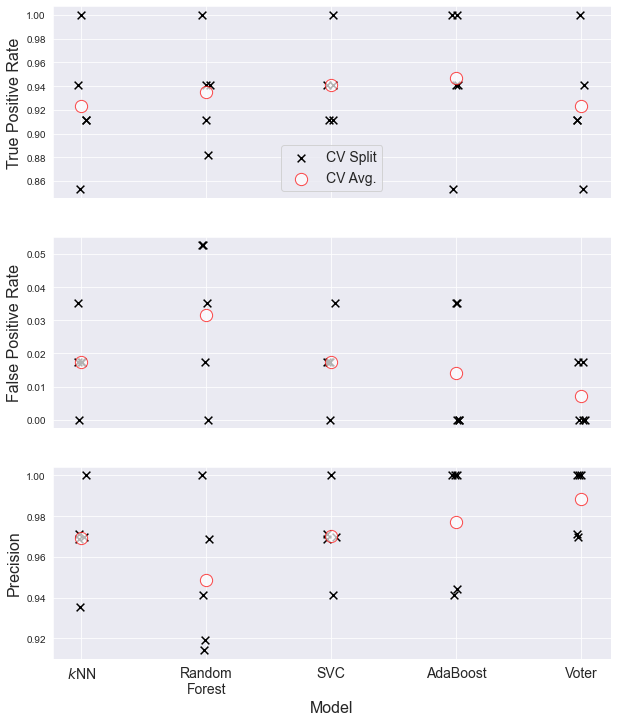

In [20]:
## Examine the performance across all 5 models.
fig,ax = plt.subplots(3,1,figsize=(10,12), sharex=True)

## TPR
for i in range(5):
    if i == 0:
        ax[0].scatter(np.ones(5)*i+np.random.uniform(low=-.04, high=.04,size=5), cv_tprs[:,i], marker='x', c='k', s=60, label="CV Split")
    else:
        ax[0].scatter(np.ones(5)*i+np.random.uniform(low=-.04, high=.04,size=5), cv_tprs[:,i], marker='x', c='k', s=60)
        
    
ax[0].scatter(range(5), np.mean(cv_tprs, axis=0), c='white', edgecolor='red', s=150, alpha=.7, label="CV Avg.")

ax[0].set_ylabel("True Positive Rate", fontsize=16)


## FPR
for i in range(5):
    ax[1].scatter(np.ones(5)*i+np.random.uniform(low=-.04, high=.04,size=5), cv_fprs[:,i], marker='x', c='k', s=60)
    
ax[1].scatter(range(5), np.mean(cv_fprs, axis=0), c='white', edgecolor='red', s=150, alpha=.7)

ax[1].set_ylabel("False Positive Rate", fontsize=16)

## Precision
for i in range(5):
    ax[2].scatter(np.ones(5)*i+np.random.uniform(low=-.04, high=.04,size=5), cv_precs[:,i], marker='x', c='k', s=60)
    
ax[2].scatter(range(5), np.mean(cv_precs, axis=0), c='white', edgecolor='red', s=150, alpha=.7)

ax[2].set_ylabel("Precision", fontsize=16)


ax[2].set_xticks([0,1,2,3,4])
ax[2].set_xticklabels(["$k$NN", "Random\nForest", "SVC", "AdaBoost", "Voter"], fontsize=14)

ax[2].set_xlabel("Model", fontsize=16)

ax[0].legend(fontsize=14)



plt.show()

<i>Which model do you choose? Why?</i>

##### Sample Solution

I am inclinded to go with the voter model since it has the highest precision, lowest false positive rate and comparable true positive rate. Note your answer may differ to this one.

##### 6. A return to interpretation

Recall from Classifying Cancer I

Common questions for diagnostic models concern estimating the probability that an individual does or does not have a disease if the model says (or does not say) they have one. We can estimate such a statistic using Bayes' rule.

$$
P\left(\text{Has Cancer} | \text{Classified } 1\right)
$$

$$
= \frac{P\left(\text{Classified } 1 | \text{Has Cancer} \right) P\left( \text{Has Cancer}  \right)}{P\left(\text{Classified } 1 | \text{Has Cancer} \right) P\left( \text{Has Cancer}  \right) + P\left(\text{Classified } 1 | \text{Does Not Have Cancer} \right) P\left( \text{Does Not Have Cancer}  \right)},
$$

similarly

$$
P\left(\text{Has Cancer} | \text{Classified } 0\right)
$$

$$
= \frac{P\left(\text{Classified } 0 | \text{Has Cancer} \right) P\left( \text{Has Cancer}  \right)}{P\left(\text{Classified } 0 | \text{Has Cancer} \right) P\left( \text{Has Cancer}  \right) + P\left(\text{Classified } 0 | \text{Does Not Have Cancer} \right) P\left( \text{Does Not Have Cancer}  \right)},
$$

We can estimate $P\left(\text{Classified } 1 | \text{Has Cancer} \right)$ with the true positive rate and we can estimate $P(\text{Has Cancer})$ or $P(\text{Does Not Have Cancer})$ using the rates from the data.

Estimate the true positive and true negative rates for your classifier using cross-validation. Then estimate $P\left(\text{Has Cancer} | \text{Classified } 1\right)$ and $P\left(\text{Has Cancer} | \text{Classified } 0\right)$ for your classifier.

##### Sample Solution

In [14]:
model_tprs = np.zeros(5)
model_fprs = np.zeros(5)
model_tnrs = np.zeros(5)
model_fnrs = np.zeros(5)

has_cancer = np.zeros(5)
no_cancer = np.zeros(5)

i = 0
for train_index, test_index in kfold.split(X_train, y_train):
    # this gets the training and holdout sets
    X_tt = X_train.iloc[train_index]
    X_ho = X_train.iloc[test_index]
    y_tt = y_train.iloc[train_index]
    y_ho = y_train.iloc[test_index]
    
    
    ## Make your model
    vote = VotingClassifier([('knn', Pipeline([('scale', StandardScaler()),
                                                ('pca', PCA(.85)),
                                                ('knn', KNeighborsClassifier(5))])),
                                ('rf', RandomForestClassifier(n_estimators = 1500,
                                                                   max_depth = 5,
                                                                   max_samples = 200,
                                                                   random_state = 330)),
                                ('svc', Pipeline([('scale', StandardScaler()),
                                                    ('pca', PCA(.9)),
                                                    ('knn', SVC(kernel='rbf'))])),
                                ('ada', AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, 
                                                                                  random_state=223), 
                                                             n_estimators=90, 
                                                             learning_rate=1))])
    
    ## Record the estimate for the malignant prevalence
    has_cancer[i] = np.sum(y_ho==1)/len(y_ho)
    no_cancer[i] = np.sum(y_ho==0)/len(y_ho)
    
    ## Train your model
    vote.fit(X_tt.values, y_tt)
    
    ## Get the prediction for your model
    pred = vote.predict(X_ho.values)
    
    conf_mat = confusion_matrix(y_ho, pred)
    
    model_tprs[i] = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
    model_fprs[i] = conf_mat[0,1]/(conf_mat[0,0] + conf_mat[0,1])
    model_tnrs[i] = conf_mat[0,0]/(conf_mat[0,0] + conf_mat[0,1])
    model_fnrs[i] = conf_mat[1,0]/(conf_mat[1,0] + conf_mat[1,1])
    
    i = i + 1

In [15]:
p_has_cancer_given_1 = model_tprs*has_cancer/(model_tprs*has_cancer + model_fprs*no_cancer)
p_has_cancer_given_0 = model_fnrs*has_cancer/(model_fnrs*has_cancer + model_tnrs*no_cancer)

In [16]:
print("If our classifier says a patient has cancer, we estimate",
      "a", np.round(np.mean(p_has_cancer_given_1),5),
      "probability that they actually have cancer.")

print()
print()

print("If our classifier says a patient does not have cancer, we estimate",
      "a", np.round(np.mean(p_has_cancer_given_0),5),
      "probability that they actually do have cancer.")

If our classifier says a patient has cancer, we estimate a 0.98823 probability that they actually have cancer.


If our classifier says a patient does not have cancer, we estimate a 0.04303 probability that they actually do have cancer.


##### 7. Model more

Feel free to make more models down below if you would like.

##### 8. Looking at the test set.

Once you have a final model that you are pleased with, retrain the model using the entire training set. Then check the TPR, FPR and precision on the test set. How does this compare with what you expected from the cross-validation above?

In [17]:
vote = VotingClassifier([('knn', Pipeline([('scale', StandardScaler()),
                                                ('pca', PCA(.85)),
                                                ('knn', KNeighborsClassifier(5))])),
                                ('rf', RandomForestClassifier(n_estimators = 1500,
                                                                   max_depth = 5,
                                                                   max_samples = 200,
                                                                   random_state = 330)),
                                ('svc', Pipeline([('scale', StandardScaler()),
                                                    ('pca', PCA(.9)),
                                                    ('knn', SVC(kernel='rbf'))])),
                                ('ada', AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, 
                                                                                  random_state=223), 
                                                             n_estimators=90, 
                                                             learning_rate=1))])

vote.fit(X_train.values, y_train)

pred = vote.predict(X_test.values)

conf_mat = confusion_matrix(y_test, pred)

In [18]:
print("Test set TPR =", np.round(conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1]), 4))
print("Test set FPR =", np.round(conf_mat[0,1]/(conf_mat[0,0] + conf_mat[0,1]), 4))
print("Test set precision = ", np.round(precision_score(y_test, pred), 4))

Test set TPR = 0.9048
Test set FPR = 0.0139
Test set precision =  0.9744


All are slightly worse than the average CV metric. However, we should not expect to hit the average CV values, remember these are an estimate of the average performance of our classifier.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2022.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)